 # Hacktober NLP Project

## Goals:
  - Identify the best predictors for programming language
  - Build models to best predict the language used

## Plan of Action:
  - Acquire
  - Prepare
  - Explore
  - Model
  - Conclusions
  

## Data Dictionary

| Target Variable | Definition |
| ----- | ----- |
| language | The main programming language used|

| Feature | Definition | Data Type |
| ----- | ----- | ----- |
| repo | The repository obtained from Github| `object` |
| language| The main programming language used | `object` |
| readme_content | The contents included in the ReadMe file | `object` |
| lem | Readme contents that have been lemmatized | `object` |

In [1]:
import pandas as pd
import numpy as np
import time
import os
from typing import Dict, List, Optional, Union, cast
from bs4 import BeautifulSoup
import requests
import warnings
warnings.filterwarnings("ignore")
from env import github_token, github_username
import wrangle as w
import explore2 as e
import model as m
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

## Acquire:
   - Web scrape data from Github
   - Download it as a json file

### We acquired data from github respositories from people signing up for Hacktoberfest

In [2]:
# function calling the acquired df
df = w.get_readme()
df

,repo,language,readme_contents
0,/AliceWonderland/hacktoberfest,HTML,# 🎃 HacktoberFest Starter Project 🎃\n\n** __Oc...
1,/fineanmol/Hacktoberfest2022,Python,Hacktoberfest-2022\n\n**Checkout this Project ...
2,/keshavsingh4522/hacktoberfest2021,Jupyter Notebook,"<div align=""centre"">\n <b>dont contribute i..."
3,/ossamamehmood/Hacktoberfest2022,Jupyter Notebook,# HacktoberFest 2022 `OPEN FIRST` Pull Request...
4,/tarunsinghofficial/HacktoberFest,Java,# HacktoberFest- Contribute to Open-Source.\n\...
...,...,...,...
125,/rituburman/hacktoberfest2020,C++,# Hacktoberfest For Everyone\nYou can start co...
126,/akanksha-raghav/Hacktoberfest2021,Jupyter Notebook,# Hacktoberfest2021\nHacktoberfest® is open to...
127,/TARANG0503/DSA-Practice,C++,## DSA Practice\nThis project is a collection ...
128,/rathoresrikant/HacktoberFestContribute,C++,Please note that the contributions made to thi...


## Prepare:
  - Use regex to clean our readme contents
  - Lemmatize the readme contents
  - Replace null values with the correct programming language
  - Split data into Train, Validate, Test

In [3]:
# creating a lemmatized column and cleaning the df
df['lem']= df.readme_contents.apply(w.clean_text)

### There are 9 different languages. We want to treat this as a classification project so we will modify the data to include the top 3 languages plus 'other'

In [4]:
# substitute language values for the top three languages
df= w.jupy_replace(df)

In [5]:
# This function gets the top three languages used. 
# If the language is not in the top three, it will replace the language with `other`
df= w.clean_lang(df)

### Create a model column which takes our lemmatized column and turns it into a string

In [6]:
# turns lem into a string
df['model']= df.lem.apply(w.join)
df.head()

,repo,language,readme_contents,lem,model
0,/AliceWonderland/hacktoberfest,html,# 🎃 HacktoberFest Starter Project 🎃\n\n** __Oc...,"[hacktoberfest, starter, project, oct, 24th, 2...",hacktoberfest starter project oct 24th 2017 up...
1,/fineanmol/Hacktoberfest2022,python,Hacktoberfest-2022\n\n**Checkout this Project ...,"[hacktoberfest2022, checkout, project, well, a...",hacktoberfest2022 checkout project well annoyi...
2,/keshavsingh4522/hacktoberfest2021,c++,"<div align=""centre"">\n <b>dont contribute i...","[div, aligncentre, bdont, contribute, repo, co...",div aligncentre bdont contribute repo contribu...
3,/ossamamehmood/Hacktoberfest2022,c++,# HacktoberFest 2022 `OPEN FIRST` Pull Request...,"[hacktoberfest, 2022, open, first, pull, reque...",hacktoberfest 2022 open first pull request fre...
4,/tarunsinghofficial/HacktoberFest,other,# HacktoberFest- Contribute to Open-Source.\n\...,"[hacktoberfest, contribute, opensource, create...",hacktoberfest contribute opensource create fir...


In [7]:
# splitting the data
train, X_train, y_train, X_val, y_val, X_test, y_test = w.split_data(df, 'language')

## Exploration

In [8]:
# creating word_freq df
word_freq= e.word_freq_new_df(df, w.clean_text)

### These words potentially seem to apply to any language - 'td', 'contribution', 'repo', 'software'

In [9]:
# displaying the word_freq df
word_freq

,readme,python,cplus+,html,other
td,187,9,162,0,16
contribution,181,55,42,23,61
repo,179,44,53,25,57
software,179,29,114,4,32
,173,29,58,0,86
...,...,...,...,...,...
interest,25,0,22,1,2
playing,25,1,24,0,0
every,25,5,10,5,5
accepted,25,8,7,6,4


### Top words from Python: contribution, language, repo, 1 - don't seem indicative of Python

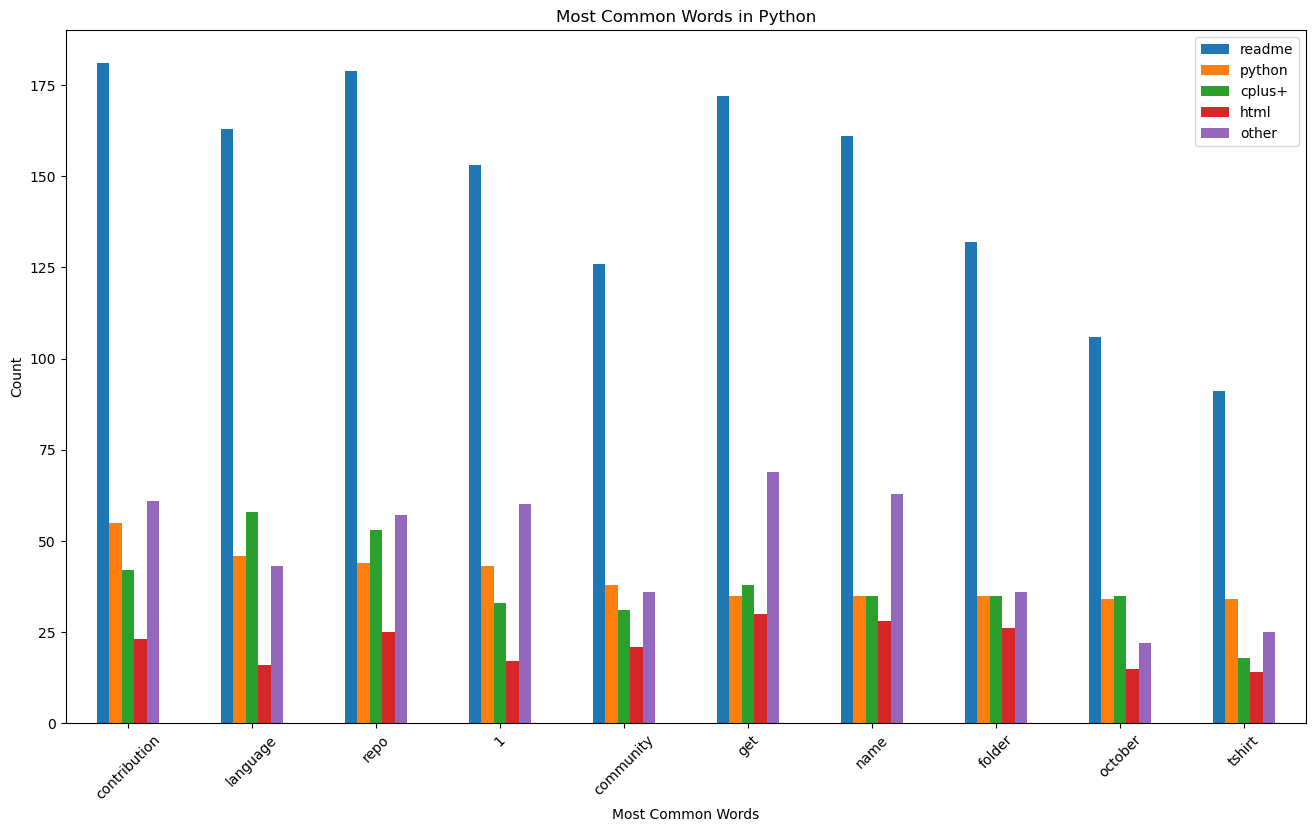

In [10]:
# visualization for python bar plot
e.python_vis(word_freq)

Python Takeaways:
- The three most common words in Python are: pr, source, and create.
- Software could also be added to this list, because it occurs rarely in HTML and other languages.
- While these are the three most common words, the words are, for the most part, distributed evenly throughout most of the programming languages.

### Top words for C++:  td, im, software, love - again, don't seem to have much to do with C++

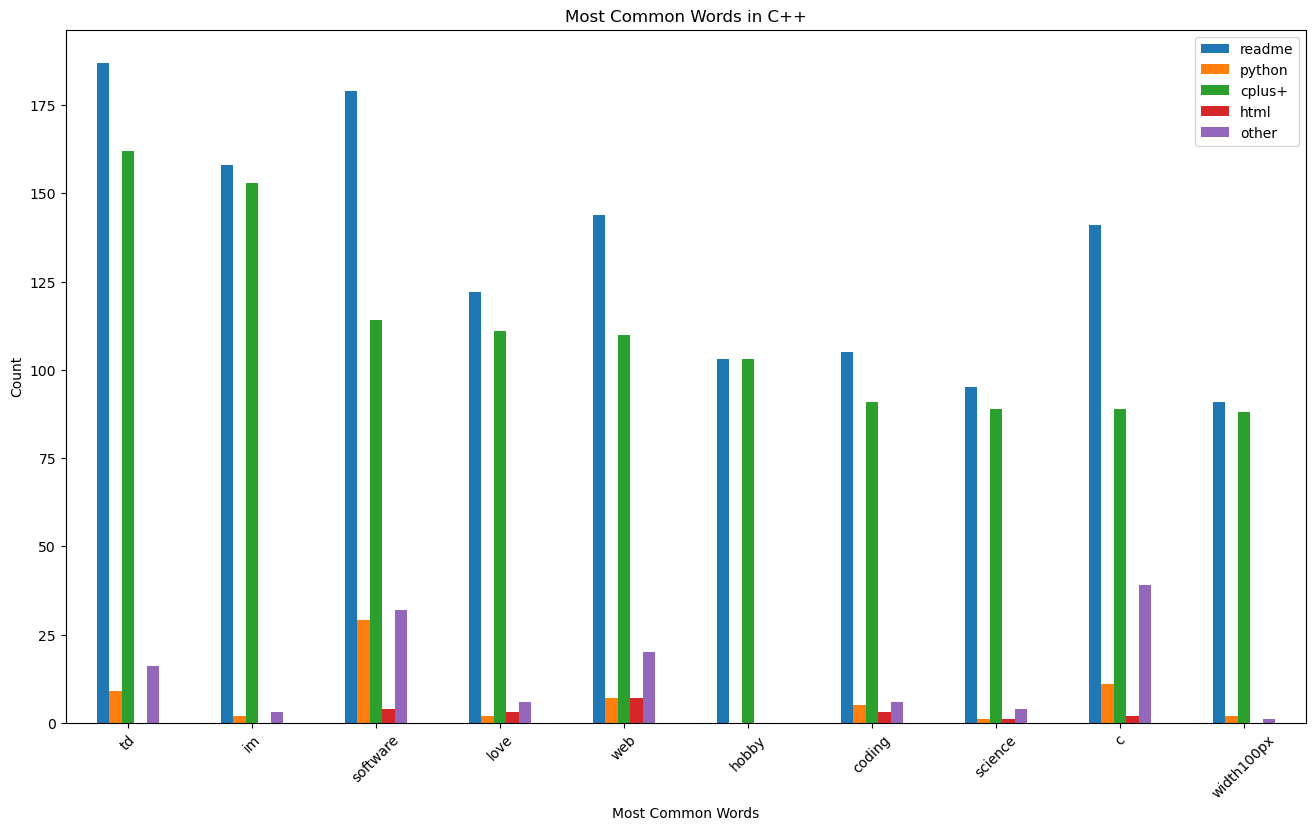

In [11]:
# visualization for C++ bar plot
e.c_plus_plus_vis(word_freq)

C++ Takeaways:
- The three most common words in C++ are: td, im, and love.
- While these are the three most common words, hobby and titlecode should be added to this list because they do not appear in HTML, Python, or any of the other languages.

### Most common words in HTML:  get, step, name, command - doesn't seem specific to HTML

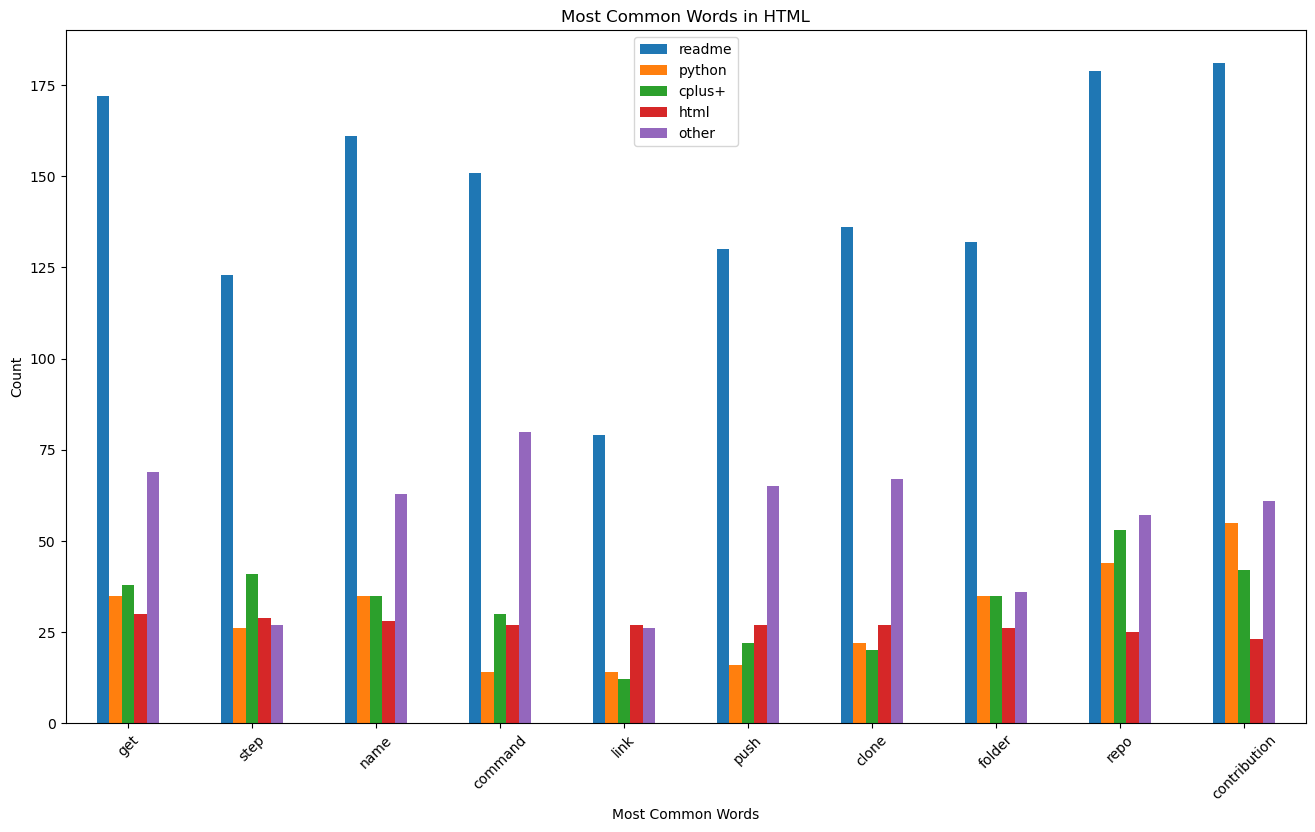

In [12]:
# visualization for HTML bar plot
e.html_vis(word_freq)

HTML Takeaways:
- The three most common words in HTML are: branch, change, and file.
- HTML appears the most evenly distributed of all the programming languages and is harder to determine a specific word or words for this language.

### Top words for 'other':  remote, ' ', width, command: not specific to HTML

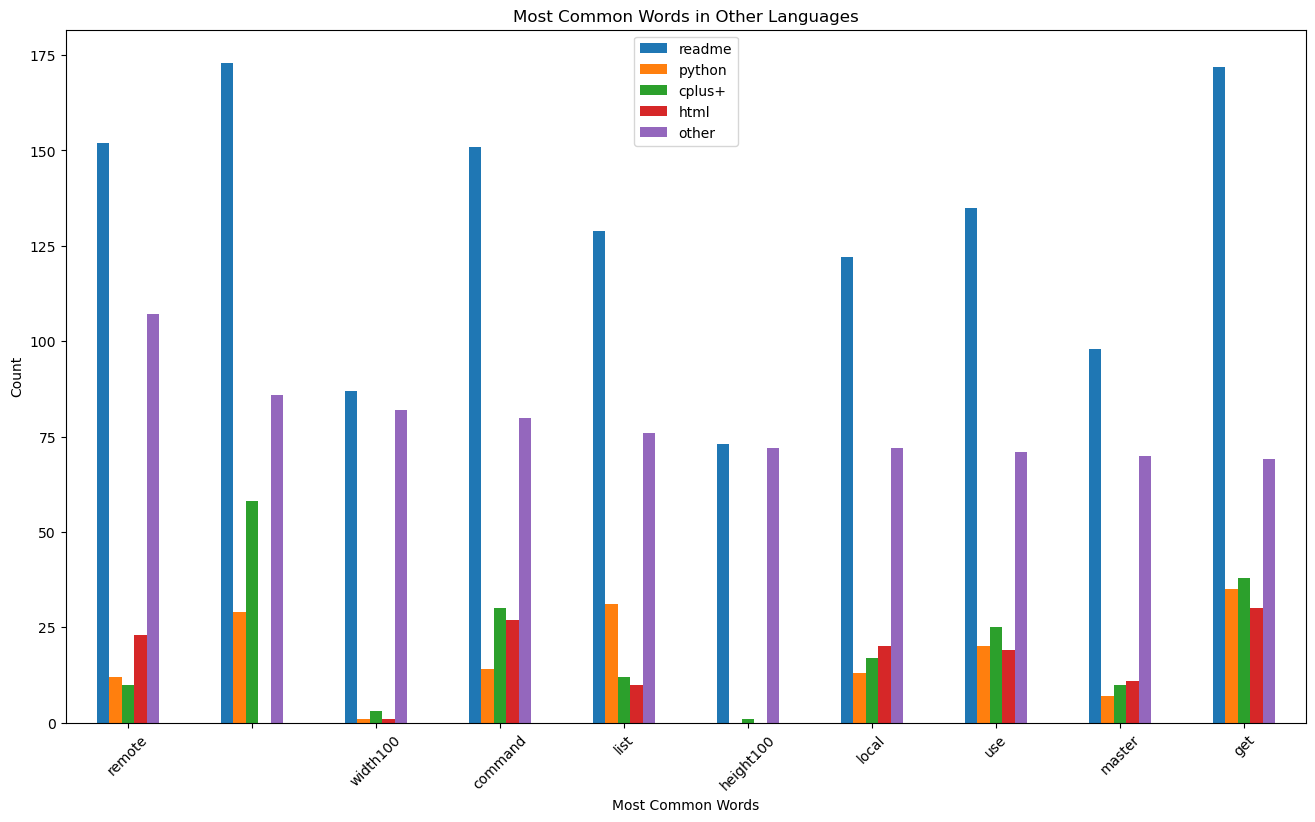

In [13]:
# visualizagtion for 'other' bar plot
e.other_vis(word_freq)

Other Takeaways:
- The three most common words in other languages are: file, source, and change.
- All of the words in the top ten for other languages are about the same.

### The error bars for the ReadMe are quite large: not a large difference in length for each language

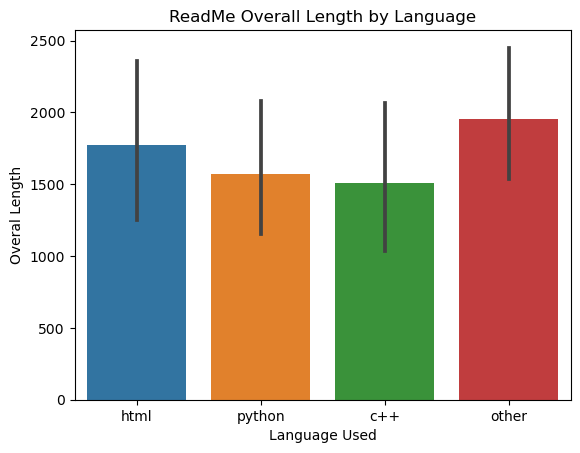

In [14]:
# visualization for overall length of README
e.length_viz(df)

Takeaway:
   - There is no significant difference in length of readme by language after a single outlier (at 50k in length) is removed.

## Summary:
   - Two of the top three words in python (pr and create) do not appear as top words in any of the other programming languages, along with software. None of the top words in C++ appeared as top words in any of the other programming languages and had the highest difference between these top words versus the three other programming languages. Only one of the top words words in HTML (branch) did not appear in the other progamming language. None of the top three programming languages appeared in the top ten of eachother. Only other had the same top words (source, file, and change) with python and mainly HTML. The top three words overall in READMEs were source, code, and td. Code did not appear in any of the top three, but source and td appeared in python, C++, and other, the top three coding languages. Based on these takeaways it appears that the words below are most related to the respective programming language:


   - Python = pr, create, and software
   
   
   - C++ = td, im, hobby, and titlecode (love could be added to this list, but might not appear in other repos not associated with hacktoberfest)
    - HTML = branch
    
    

## Modeling
  - Used the found predictors from explore to make models
  - The best model was 

### Because we have 4 potential languages our baseline's model accuracy is quite low. 'Other' occurs 33% of the time.

In [15]:
# print baseline
m.print_baseline(y_train)

0.33


In [16]:
# create sparse matrices
tfidf_train, tfidf_val, tfidf_test= m.tfidf(X_train, X_val, X_test)

In [17]:
# run models
y_train, y_val, y_test = m.run_models(y_train, y_val, y_test, tfidf_train, tfidf_val, tfidf_test)

### Our models perform quite well on the train set and fail miserably on the validate set. This is signs of overfitting. We'll choose our Decision Tree as our best model as the difference in performance between Train and Validate is the smallest.

In [18]:
# create accruacy df
acc= m.accuracy_df(y_train,y_val)
acc

,train,validate
model,,
predict_lm,0.861111,0.37500
predict_rf,1.000000,0.28125
predict_knn,0.541667,0.31250
predict_dt,0.527778,0.31250


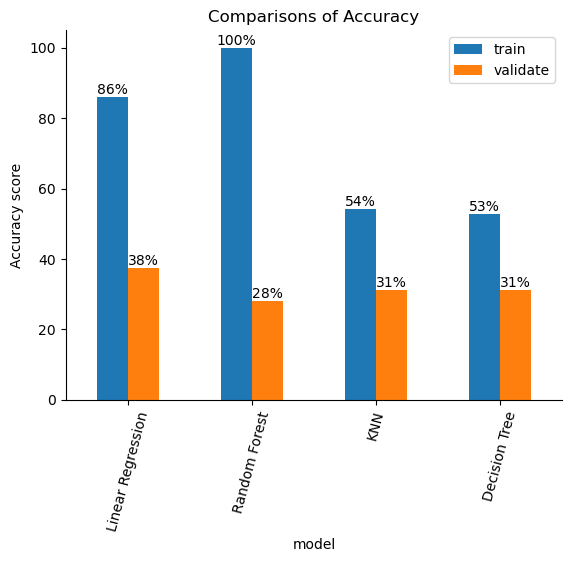

In [19]:
# visualization for accuracy
m.viz_models_accuracy(acc)

### Even though our model achieved an accuracy of 46% on the Test Set, we expect it to perform more in line with our Baseline model of 33%. Our Test Set is quite small and we think most of the success of our model is simply luck.

In [20]:
# printing accuracy on test
m.print_accuracy(y_test,'predict_dt')

Accuracy: 46.15%
---


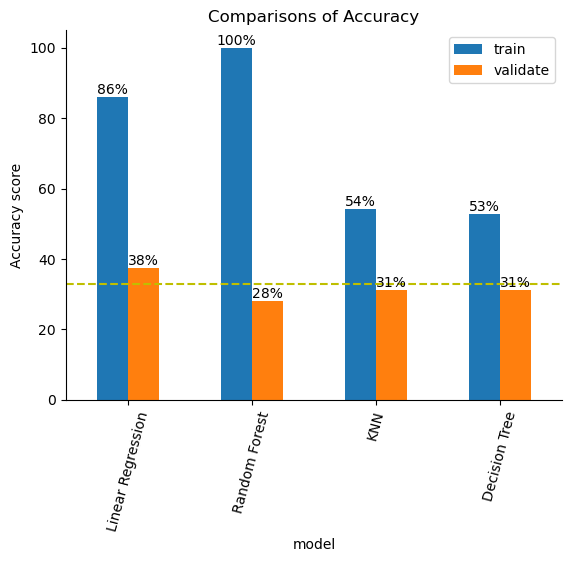

In [21]:
e.viz_models_accuracy(acc)

## Model Conclusion:
   - While our model achieved an accuracy of 46% on the test set, beating our baseline by 13%, it only achieved an accuracy of 31% on the validate set
   - Expect the model to perform roughly at the level as the baseline model
   

# Takeaways

- Two of the top three words in python (pr and create) do not appear as top words in any of the other programming languages, along with software.
- None of the top words in C++ appeared as top words in any of the other programming languages and had the highest difference between these top words versus the three other programming languages.
- Only one of the top words words in HTML (branch) did not appear in the other progamming language.
- None of the top three programming languages appeared in the top ten of eachother.
- Only other had the same top words (source, file, and change) with python and mainly HTML.
- The top three words overall in READMEs were source, code, and td. Code did not appear in any of the top three, but source and td appeared in python, C++, and other, the top three coding languages.

# Recommendations

- Based on these takeaways it appears that the words below are most related to the respective programming language:
    - Python = pr, create, and software
    - C++ = td, im, hobby, and titlecode
    - HTML = branch

# Next Steps

- Explore quadgrams.
- Add more stopwords to the list.
- Readjust the parameters for max and min words.